<a href="https://colab.research.google.com/github/saurater/ciencia_de_dados_pyspark/blob/main/PySpark_Desafio_M%C3%B3dulo_2_Cen%C3%A1rio_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spark MLLib Árvore de Decisão - Previsão de Derrame - Desafio - Cenário 2

Sam Faraday

In [1]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importando SparkSession e criando o app com o nome de Minha_MLLIB

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName("Desafio").getOrCreate()

# Pipeline de Machine Learning

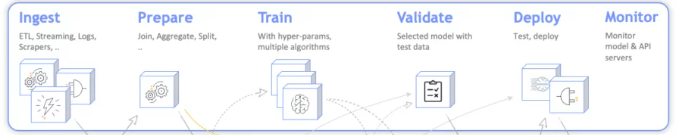

# Pipeline: 1 - Ingest - Fase de Aquisição do Dados

In [4]:
df_derrame = spark.read.csv("stroke_data.csv", header = True, inferSchema= True)

In [5]:
df_derrame.describe().show()

+-------+------------------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+------------------+---------------+-------------------+
|summary|                 0|gender|               age|       hypertension|      heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi| smoking_status|             stroke|
+-------+------------------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+------------------+---------------+-------------------+
|  count|             67135| 67135|             67135|              67135|              67135|       67135|    67135|         67135|             67135|             67135|          67135|              67135|
|   mean|           33568.0|  null| 51.95950845311693|0.16410218217025396|0.10142250688910405|        null|     null|          null|113.41439606762462| 29.16154047813857|  

# Pergunta 1
Quantos registros existem no arquivo?

**Resposta: 67.135**

# Pipeline: 2 - Prepare - Análise e Preparação dos Dados

1. Análise de Missing Values (Valores Faltantes)
2. Feature Selection (Seleção de colunas): adição ou remoção de colunas - features de acordo com suas relavâncias
3. Análise dos tipos das features:
    Integer - String - Categórico - Númerico

## Analisando as Features e seu Tipos

In [6]:
df_derrame.printSchema()

root
 |-- 0: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



# Pergunta 2
Quantas colunas existem no arquivo? Quantas são numéricas? 

Ao ler o arquivo com spark.read.csv, habilite inferSchema=True. Use a função printSchema() da API de Dataframes.

**Resposta: 12 e 7**

In [7]:
total_colunas = 0 
qtd_string = 0
qtd_nao_string = 0
for colunas in df_derrame.dtypes:
  total_colunas = total_colunas + 1
  if colunas[1] == 'string':
    qtd_string  = qtd_string + 1
  else:
    qtd_nao_string  = qtd_nao_string + 1


print("Total de " + str(total_colunas) + " Colunas \n" + str(qtd_string) + " são Strings \n"  + str(qtd_nao_string) + " são Numéricas")

Total de 12 Colunas 
5 são Strings 
7 são Numéricas


# Verificando Missing ou Null Values
Null, None, NaN

In [8]:
from pyspark.sql.functions import col,isnan, when, count

In [9]:
df_derrame.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_derrame.columns]).show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|  0|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



## Análise Visual dos Dados

Aqui já identificamos:
1. Missing Values como pontos de interrogação nas features Tipo e Ocupação e deverão ser removidos

2. Também percebemos, por conhecimento de negócio, que a feature Peso Final não tem importância para nossas análises e deverá ser dropada

In [10]:
df_derrame.show(5)

+---+------+----+------------+-------------+------------+-------------+--------------+-----------------+-----+---------------+------+
|  0|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|  bmi| smoking_status|stroke|
+---+------+----+------------+-------------+------------+-------------+--------------+-----------------+-----+---------------+------+
|  1|Female|18.0|           0|            0|          No|      Private|         Urban|            94.19|12.12|         smokes|     1|
|  2|  Male|58.0|           1|            0|         Yes|      Private|         Rural|           154.24| 33.7|   never_smoked|     0|
|  3|Female|36.0|           0|            0|         Yes|     Govt_job|         Urban|            72.63| 24.7|         smokes|     0|
|  4|Female|62.0|           0|            0|         Yes|Self-employed|         Rural|            85.52| 31.2|formerly smoked|     0|
|  5|Female|82.0|           0|            0|         Yes|     

## Análise Estatística

In [11]:
df_derrame.select('age').summary().show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|             67135|
|   mean| 51.95950845311693|
| stddev|23.413054156327913|
|    min|              0.08|
|    25%|              35.0|
|    50%|              56.0|
|    75%|              73.0|
|    max|              82.0|
+-------+------------------+



In [12]:
df_derrame.groupBy('hypertension').count().sort("count", ascending=False).show()

+------------+-----+
|hypertension|count|
+------------+-----+
|           0|56118|
|           1|11017|
+------------+-----+



In [13]:
df_derrame.groupBy('gender').count().sort("count", ascending=False).show()

+------+-----+
|gender|count|
+------+-----+
|Female|39530|
|  Male|27594|
| Other|   11|
+------+-----+



In [14]:
df_derrame.groupBy('ever_married').count().sort("count", ascending=False).show()

+------------+-----+
|ever_married|count|
+------------+-----+
|         Yes|49323|
|          No|17812|
+------------+-----+



In [15]:
df_derrame.groupBy('work_type').count().sort("count", ascending=False).show()

+-------------+-----+
|    work_type|count|
+-------------+-----+
|      Private|37806|
|Self-employed|14736|
|     Govt_job| 8260|
|     children| 6156|
| Never_worked|  177|
+-------------+-----+



In [16]:
df_derrame.groupBy('Residence_type').count().sort("count", ascending=False).show()

+--------------+-----+
|Residence_type|count|
+--------------+-----+
|         Urban|34023|
|         Rural|33112|
+--------------+-----+



In [17]:
df_derrame.groupBy('smoking_status').count().sort("count", ascending=False).show()

+---------------+-----+
| smoking_status|count|
+---------------+-----+
|         smokes|35963|
|formerly smoked|17880|
|   never_smoked|13292|
+---------------+-----+



In [18]:
df_derrame.groupBy('stroke').count().sort("count", ascending=False).show()

+------+-----+
|stroke|count|
+------+-----+
|     1|40287|
|     0|26848|
+------+-----+



# Pergunta 3
No conjunto de dados, quantos pacientes sofreram e não sofreram derrame (stroke), respectivamente?

**Resposta: 40287 e 26848**

# Pergunta 4
A partir do dataframe, crie uma tabela temporária usando df.createOrReplaceTempView('table') e a seguir use spark.sql para escrever uma consulta SQL que obtenha 

**Quantos pacientes tiveram derrame por tipo de trabalho (work_type)**. 

**Quantos pacientes sofreram derrame e trabalhavam respectivamente no setor privado** 

Resposta: 23.711

**Quantos de forma independente** 

Resposta: 10.807

**Quantas no Governo?**

Resposta: 5.164

**Quantas são Crianças**?

Resposta: 520

In [19]:
#Criando uma View Temporária para trabalhamos com SQL
df_derrame.createOrReplaceTempView("derrames")

In [20]:
df_derrame.printSchema()

root
 |-- 0: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [21]:
# Quantos pacientes tiveram derrame por tipo de trabalho (work_type).
spark.sql("select work_type, count(work_type) as Total from derrames where stroke = 1 group by work_type ").show()

+-------------+-----+
|    work_type|Total|
+-------------+-----+
| Never_worked|   85|
|Self-employed|10807|
|      Private|23711|
|     children|  520|
|     Govt_job| 5164|
+-------------+-----+



# Pergunta 5
Escreva uma consulta com spark.sql para determinar a proporção, por gênero, de participantes do estudo. A maioria dos participantes é:

**Resposta: Feminino**

In [22]:
# Com SQL
spark.sql("select gender, count(gender) as Total from derrames  group by gender ").show()

+------+-----+
|gender|Total|
+------+-----+
|Female|39530|
| Other|   11|
|  Male|27594|
+------+-----+



In [23]:
# Com DataFrame
df_derrame.groupBy('gender').count().sort("count", ascending=False).show()

+------+-----+
|gender|count|
+------+-----+
|Female|39530|
|  Male|27594|
| Other|   11|
+------+-----+



# Pergunta 6
Escreva uma consulta com spark.sql para determinar quem tem mais probabilidade de sofrer derrame: hipertensos ou não-hipertensos. Você pode escrever uma consulta para cada grupo. A partir das probabilidades que você obteve, você conclui que: **A hipertensão, neste conjunto de dados, diminui a probabilidade de derrame.**

In [24]:
spark.sql("select hypertension, count(hypertension) as Total \
from derrames\
 where stroke = 1\
 group by hypertension").show()

+------------+-----+
|hypertension|Total|
+------------+-----+
|           1| 8817|
|           0|31470|
+------------+-----+



# Pergunta 7
Escreva uma consulta com spark.sql que determine o número de pessoas que sofreram derrame por idade. Com qual idade o maior número de pessoas do conjunto de dados sofreu derrame?

**Resposta: 79**

In [25]:
spark.sql("select age, count(age) as Total\
 from derrames\
  where stroke = 1\
   group by age\
     order by count(age) desc").show()

+----+-----+
| age|Total|
+----+-----+
|79.0| 2916|
|78.0| 2279|
|80.0| 1858|
|81.0| 1738|
|82.0| 1427|
|77.0|  994|
|74.0|  987|
|63.0|  942|
|76.0|  892|
|70.0|  881|
|66.0|  848|
|75.0|  809|
|67.0|  801|
|57.0|  775|
|73.0|  759|
|65.0|  716|
|72.0|  709|
|68.0|  688|
|69.0|  677|
|71.0|  667|
+----+-----+
only showing top 20 rows



#Pergunta 8
Usando a API de dataframes, determine quantas pessoas sofreram derrames após os 50 anos.

**Resposta: 28.938**

In [26]:
df_derrame.select('age').where((df_derrame.age > 50) & (df_derrame.stroke == 1)).count()

28938

In [27]:
spark.sql("select count(age) as Total\
 from derrames\
  where stroke = 1 and age > 50\
     order by count(age) desc").show()

+-----+
|Total|
+-----+
|28938|
+-----+



# Pergunta 9
Usando spark.sql, determine qual o nível médio de glicose para pessoas que, respectivamente, sofreram e não sofreram derrame.

**Resposta: 119 e 103**

In [28]:
spark.sql("select stroke, (avg(avg_glucose_level)) as Total from derrames group by stroke").show()

+------+------------------+
|stroke|             Total|
+------+------------------+
|     1|119.95307046938272|
|     0|103.60273130214506|
+------+------------------+



# Pergunta 10
Qual é o BMI (IMC = índice de massa corpórea) médio de quem sofreu e não sofreu derrame?

In [29]:
spark.sql("select stroke, round(avg(bmi), 2) as Total from derrames group by stroke").show()

+------+-----+
|stroke|Total|
+------+-----+
|     1|29.94|
|     0|27.99|
+------+-----+



## Dados Categóricos x Dados Numéricos
Ao aplicar algoritmo de Machine Learning sempre estaremos trabalhando com números, assim, precisamos separar as features categóricas e as numéricas, aplicando StringIndexer nas categóricas e OnehotEnconder na Numérica

Por exemplo, a coluna sexo, como só tem dois tipos, sseus dados serão convertidos para 0 = Masculino e 1 = Feminino. Note que essa ordem pode mudar

In [30]:
# Importando StringIndexer e OneHotEncoder
from pyspark.ml.feature import StringIndexer, OneHotEncoder

In [31]:
df_derrame.printSchema()

root
 |-- 0: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [32]:
#criando a lista colunas_categoricas
#colunas_categoricas = ["gender" , "ever_married", "work_type" , "Residence_type", "smoking_status"]
colunas_categoricas = ["gender" , "smoking_status"]

In [33]:
#verificando o tipo
type(colunas_categoricas)

list

In [34]:
#vendo os dados da lista criada
colunas_categoricas

['gender', 'smoking_status']

In [35]:
df_derrame.show()

+---+------+----+------------+-------------+------------+-------------+--------------+-----------------+-----+---------------+------+
|  0|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|  bmi| smoking_status|stroke|
+---+------+----+------------+-------------+------------+-------------+--------------+-----------------+-----+---------------+------+
|  1|Female|18.0|           0|            0|          No|      Private|         Urban|            94.19|12.12|         smokes|     1|
|  2|  Male|58.0|           1|            0|         Yes|      Private|         Rural|           154.24| 33.7|   never_smoked|     0|
|  3|Female|36.0|           0|            0|         Yes|     Govt_job|         Urban|            72.63| 24.7|         smokes|     0|
|  4|Female|62.0|           0|            0|         Yes|Self-employed|         Rural|            85.52| 31.2|formerly smoked|     0|
|  5|Female|82.0|           0|            0|         Yes|     

## Indexando as Features Categóricas - StringIndexer
Note que além de indexar (transformar em índice / número), também vamos dar um novo nome para as colunas indexadas com esse código " *x + "_Indexada" for x in colunas_categoricas* ", elas aparecerão com o sufixo _Indexada. Assim, teremos a coluna tipo e a tipo_Indexada. Veremos mais à frente

In [36]:
indexador_de_strings = StringIndexer(inputCols = colunas_categoricas, outputCols = [x + "_Indexada" for x in colunas_categoricas])
#stringIndexer

# Transformando em Binários - OneHotEncoder
Transformação que fazemos nos dados para representarmos uma variável categórica de forma binária

In [37]:
meu_codificador_numerico = OneHotEncoder(inputCols = indexador_de_strings.getOutputCols() , outputCols= [x + "_OHE" for x in colunas_categoricas])
#oneHotEnconder

## Separando nossa coluna alvo, stroke (derrame) e a indexando

In [38]:
coluna_rotulo_indexada =  StringIndexer(inputCol="stroke", outputCol= "stroke_rotulo")
#labelToIndex

## Criando o Montador de Vetores - VectorAssembler

VectorAssembler é um transformador que combina uma dada lista de colunas em uma única coluna de vetores.

In [39]:
#importanfo a Lib VectorAssembler
from pyspark.ml.feature import VectorAssembler

In [40]:
df_derrame.printSchema()

root
 |-- 0: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



## Criando a Lista com as Features Numéricas

In [41]:
colunas_numericas = ["age", "hypertension", "heart_disease", "avg_glucose_level" ,"bmi"]
#numericCols
colunas_numericas

['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

## Juntando as Colunas Categóricas e as Numéricas em uma Única Lista
### E acrescentando o sufixo _OHE (que vem de OneHotEncoder) 
### apenas para fins didáticos

o sufico é acrescido com *c + "_OHE" for  c  in colunas_categoricas*

In [42]:
todas_as_colunas = [c + "_OHE" for  c  in colunas_categoricas] + colunas_numericas
#allCols
todas_as_colunas 

['gender_OHE',
 'smoking_status_OHE',
 'age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'bmi']

In [43]:
df_derrame.printSchema()

root
 |-- 0: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



## Montando o Vetor com todas as Colunas (Features)

In [44]:
#montador_de_vetores = VectorAssembler( inputCols = colunas_numericas, outputCol = "minhas_features")
montador_de_vetores = VectorAssembler( inputCols = todas_as_colunas, outputCol = "minhas_features")
#vecAssembler

# Pipeline: 3 Treinando o Modelo

## Importando a Lib DecisionTreeClassifier
Classificado Árvore de Decisão - um dos vários Algorítmos de Machine Learning

In [45]:
from pyspark.ml.classification import DecisionTreeClassifier

## Criando o classificador
Informando qual a coluna rótulo (labelcol) - a que queremos prever: derrame_rotulo, bem como a lista de features

In [46]:
classificador_arvore_de_decisao = DecisionTreeClassifier(labelCol="stroke_rotulo", featuresCol="minhas_features")
#dtc

## Criando o Pipeline do Spark
Aqui passamos para ele tudo o que construimos lá até aqui

In [47]:
#importando a lib PipeLine
from pyspark.ml import Pipeline

In [48]:
meu_pipeline = Pipeline(stages = [ indexador_de_strings, meu_codificador_numerico,coluna_rotulo_indexada, montador_de_vetores, classificador_arvore_de_decisao])
#meu_pipeline= Pipeline(stages = [ indexador_de_strings, meu_codificador_numerico,coluna_prevista_indexada, montador_de_vetores, classificador_arvore_de_decisao])

## Separando os Dados em Treino e Teste
Geralmente pegamos 70% (0.7) dos dados para Treino e 30% (0.3) para Teste

In [49]:
#Vamos relembrar quantos dados gerais temos no df_derrame
df_derrame.count() 

67135

In [50]:
#df_derrame_numerico = df_derrame.select("age", "hypertension", "heart_disease", "avg_glucose_level" , "bmi", "stroke")
df_derrame_cenario_2 = df_derrame.select("gender", "age", "hypertension", "heart_disease", "avg_glucose_level" , "bmi","smoking_status", "stroke")

df_derrame_cenario_2.show()

+------+----+------------+-------------+-----------------+-----+---------------+------+
|gender| age|hypertension|heart_disease|avg_glucose_level|  bmi| smoking_status|stroke|
+------+----+------------+-------------+-----------------+-----+---------------+------+
|Female|18.0|           0|            0|            94.19|12.12|         smokes|     1|
|  Male|58.0|           1|            0|           154.24| 33.7|   never_smoked|     0|
|Female|36.0|           0|            0|            72.63| 24.7|         smokes|     0|
|Female|62.0|           0|            0|            85.52| 31.2|formerly smoked|     0|
|Female|82.0|           0|            0|            59.32| 33.2|         smokes|     1|
|Female|82.0|           0|            0|            234.5| 24.0|formerly smoked|     0|
|Female|33.0|           0|            0|           193.42| 29.9|         smokes|     0|
|Female|37.0|           0|            0|            156.7| 36.9|         smokes|     1|
|Female|41.0|           0|      

In [51]:
#df_dados_de_treino, df_dados_de_teste = df_derrame.randomSplit([0.7, 0.3])
#df_dados_de_treino, df_dados_de_teste = df_derrame_numerico.randomSplit([0.7, 0.3])
df_dados_de_treino, df_dados_de_teste = df_derrame_cenario_2.randomSplit([0.7, 0.3])

In [52]:
# Verificando se temos 70% dos Dados do DF_derrame no DF_DADOS_DE_TREINO
df_dados_de_treino.count()

47167

In [53]:
df_dados_de_treino.show(10)

+------+----+------------+-------------+-----------------+----+--------------+------+
|gender| age|hypertension|heart_disease|avg_glucose_level| bmi|smoking_status|stroke|
+------+----+------------+-------------+-----------------+----+--------------+------+
|Female|0.08|           0|            0|            67.55|31.2|  never_smoked|     0|
|Female|0.08|           0|            0|           108.82|16.7|  never_smoked|     0|
|Female|0.08|           0|            0|           111.09|12.2|  never_smoked|     0|
|Female|0.08|           0|            0|           135.52|12.8|  never_smoked|     0|
|Female|0.16|           0|            0|            60.67|13.8|  never_smoked|     0|
|Female|0.16|           0|            0|            70.87|14.7|  never_smoked|     0|
|Female|0.16|           0|            0|            81.42|15.4|  never_smoked|     0|
|Female|0.16|           0|            0|            89.07|15.7|  never_smoked|     0|
|Female|0.16|           0|            0|            90

In [54]:
# Verificando se temos 30% dos Dados do DF_derrame no DF_DADOS_DE_TESTE
df_dados_de_teste.count()

19968

In [55]:
df_dados_de_teste.show(10)

+------+----+------------+-------------+-----------------+----+--------------+------+
|gender| age|hypertension|heart_disease|avg_glucose_level| bmi|smoking_status|stroke|
+------+----+------------+-------------+-----------------+----+--------------+------+
|Female|0.08|           0|            0|            93.97|13.1|  never_smoked|     0|
|Female|0.08|           0|            0|           106.31|15.8|  never_smoked|     0|
|Female|0.08|           0|            0|           125.11|12.1|  never_smoked|     0|
|Female|0.08|           0|            0|           139.67|14.1|  never_smoked|     0|
|Female|0.16|           0|            0|            98.52|13.1|  never_smoked|     0|
|Female|0.16|           0|            0|            99.25|12.0|  never_smoked|     0|
|Female|0.24|           0|            0|            57.62|14.1|  never_smoked|     0|
|Female|0.24|           0|            0|            60.64|14.8|  never_smoked|     0|
|Female|0.24|           0|            0|            89

In [56]:
# Verificando se a soma dos 2 DF's é igual ao do DF_derrame 
if (df_dados_de_treino.count() + df_dados_de_teste.count()) == df_derrame.count():
  print("Deu legal :) ")
else:
  print("Deu pau. Dá uma olhada no que pode ter acontecido aí")  

Deu legal :) 


## Ufa, Finalmente hora de Treinar o Modelo

Fazemos isso com o fit (ajustar) do Pipeline

In [57]:
meu_modelo_pipeline = meu_pipeline.fit(df_dados_de_treino)

In [58]:
minha_arvore = meu_modelo_pipeline.stages
display(minha_arvore)
len(minha_arvore)

[StringIndexerModel: uid=StringIndexer_256454996623, handleInvalid=error, numInputCols=2, numOutputCols=2,
 OneHotEncoderModel: uid=OneHotEncoder_401d1cbed3cc, dropLast=true, handleInvalid=error, numInputCols=2, numOutputCols=2,
 StringIndexerModel: uid=StringIndexer_71d885d2bafa, handleInvalid=error,
 VectorAssembler_5cd644e6f249,
 DecisionTreeClassificationModel: uid=DecisionTreeClassifier_32f25071617c, depth=5, numNodes=31, numClasses=2, numFeatures=9]

5

## Blz, Vamos, agora, aplicar nos dados de Teste o que foi Aprendido no Treino
Fazemos isso com o *transform* do Pipeline e jogamos em um novo DF, o DF_DADOS_PARA_PREDICAO

In [59]:
df_dados_para_predicao = meu_modelo_pipeline.transform(df_dados_de_teste)

## Agora, vamos analisar o DF com os dados de Predição DF_DADOS_PARA_PREDICAO

In [60]:
df_dados_para_predicao.show(10)

+------+----+------------+-------------+-----------------+----+--------------+------+---------------+-----------------------+-------------+------------------+-------------+--------------------+-------------+--------------------+----------+
|gender| age|hypertension|heart_disease|avg_glucose_level| bmi|smoking_status|stroke|gender_Indexada|smoking_status_Indexada|   gender_OHE|smoking_status_OHE|stroke_rotulo|     minhas_features|rawPrediction|         probability|prediction|
+------+----+------------+-------------+-----------------+----+--------------+------+---------------+-----------------------+-------------+------------------+-------------+--------------------+-------------+--------------------+----------+
|Female|0.08|           0|            0|            93.97|13.1|  never_smoked|     0|            0.0|                    2.0|(2,[0],[1.0])|         (2,[],[])|          1.0|(9,[0,4,7,8],[1.0...|[43.0,8263.0]|[0.00517698049602...|       1.0|
|Female|0.08|           0|            0|

## Observe que as colunas do Tipo String foram Triplicadas
Por exemplo, agora temos as colunas gender, gender_Indexada e gender_OHE


In [61]:
#Criando uma View Temporária para trabalhamos com SQL
df_dados_para_predicao.createOrReplaceTempView("predicoes")
#Dando Select nas colunas tipo
spark.sql(" select *  from predicoes order by 2 desc").show(10)
# Altere esse selec para ver outras colunas como educacao, educacao_Indexada, educacao_OHE

+------+----+------------+-------------+-----------------+----+--------------+------+---------------+-----------------------+-------------+------------------+-------------+--------------------+--------------+--------------------+----------+
|gender| age|hypertension|heart_disease|avg_glucose_level| bmi|smoking_status|stroke|gender_Indexada|smoking_status_Indexada|   gender_OHE|smoking_status_OHE|stroke_rotulo|     minhas_features| rawPrediction|         probability|prediction|
+------+----+------------+-------------+-----------------+----+--------------+------+---------------+-----------------------+-------------+------------------+-------------+--------------------+--------------+--------------------+----------+
|Female|82.0|           0|            0|            56.54|20.4|        smokes|     0|            0.0|                    0.0|(2,[0],[1.0])|     (2,[0],[1.0])|          1.0|[1.0,0.0,1.0,0.0,...|[6576.0,294.0]|[0.95720524017467...|       0.0|
|Female|82.0|           0|          

# Pipeline 4: Validar

## Vamos Analisar as Predições?
Como temos apenas cerca de 83% de acurácia (veja próxima seção) , teremos alguns imprecisões, ora Maior que 50 Mil será previsto corretamente, 0, ora com erro, 1

In [62]:
spark.sql(" select stroke , prediction from predicoes order by rand()").show(10)

+------+----------+
|stroke|prediction|
+------+----------+
|     1|       0.0|
|     1|       0.0|
|     0|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     0|       1.0|
|     1|       0.0|
|     1|       0.0|
|     0|       1.0|
+------+----------+
only showing top 10 rows



## Importando MulticlassClassificationEvaluator para Avaliações

In [63]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

## Vamos Criar um Avaliador usando a Métrica Acurácia

In [64]:
avaliador = MulticlassClassificationEvaluator(metricName="accuracy",labelCol="stroke_rotulo")
#evaluator

# **Pergunta 11 - Cenário 1 - Veja o Notebook Cenário I**
Crie um modelo de árvore de decisão que prevê a chance de derrame (stroke) a partir das variáveis contínuas/categóricas: idade, BMI, hipertensão, doença do coração, nível médio de glicose. Use o conteúdo da segunda aula interativa para criar e avaliar o modelo.

Qual a acurácia de um modelo construído?

Resposta: **Acurácia** : 68.71336313959264 %

# Pergunta 12 - **Cenário2**

Adicione ao modelo as variáveis categóricas: gênero e status de fumante. Use o conteúdo da aula interativa para lidar com as variáveis categóricas.  A acurácia (qualidade) do modelo aumentou para:

Resposta: **Acurácia**: Acima de 80 (83.21726675556873 %)

In [65]:
print(f"Acurácia :  {  (avaliador.evaluate(df_dados_para_predicao) * 100) } %")

Acurácia :  83.87920673076923 %


# Pergunta 13

Qual dessas variáveis é mais importante no modelo de árvore de decisão que você construiu na questão (12)?

1. Nível médio de glicose.

2. **Ter hipertensão.**
**Nota: A resposta correta deveria ser Idade, mas não aparece na lista**

3. Status sobre fumo.

4. Ter doença cardíaca.

In [66]:
va           = meu_modelo_pipeline.stages[-2]
minha_arvore = meu_modelo_pipeline.stages[-1]

importancia_de_features = list(zip(va.getInputCols(), minha_arvore.featureImportances))

In [67]:
import pandas as pd
colunas = ["Feature / Coluna", "Importância"]
importancia_de_features = pd.DataFrame(importancia_de_features, columns = colunas)
importancia_de_features.sort_values(by=['Importância'], ascending=False, inplace=True)
importancia_de_features

,Feature / Coluna,Importância
2,age,0.486544
3,hypertension,0.330430
4,heart_disease,0.173199
5,avg_glucose_level,0.000489
0,gender_OHE,0.000000
1,smoking_status_OHE,0.000000
6,bmi,0.000000


#Pergunta 14
Qual a profundidade da árvore de decisão da questão (12)?

1. Entre 2 e 7.

2. Menor que 1.

3. Menor que 2.

4. Maior que 5.

In [68]:
minha_arvore =  meu_modelo_pipeline.stages[-1]
display(minha_arvore)
print("\nProfundidade: ", (minha_arvore.depth))

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_32f25071617c, depth=5, numNodes=31, numClasses=2, numFeatures=9


Profundidade:  5


# Pergunta 15
Quantos nodos a árvore de decisão possui?

1. 1

2. 3

3. **Mais que 5.**

4. 2

In [69]:
display(minha_arvore)
print("\nNúmero de Nós: ", (minha_arvore.numNodes))

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_32f25071617c, depth=5, numNodes=31, numClasses=2, numFeatures=9


Número de Nós:  31
